In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape, label_batch.numpy())
    print(label_batch[0])


(32, 256, 256, 3) [1 0 1 2 0 0 1 0 1 1 2 1 1 0 1 1 1 1 0 1 2 0 0 1 0 2 1 1 0 1 1 0]
tf.Tensor(1, shape=(), dtype=int32)


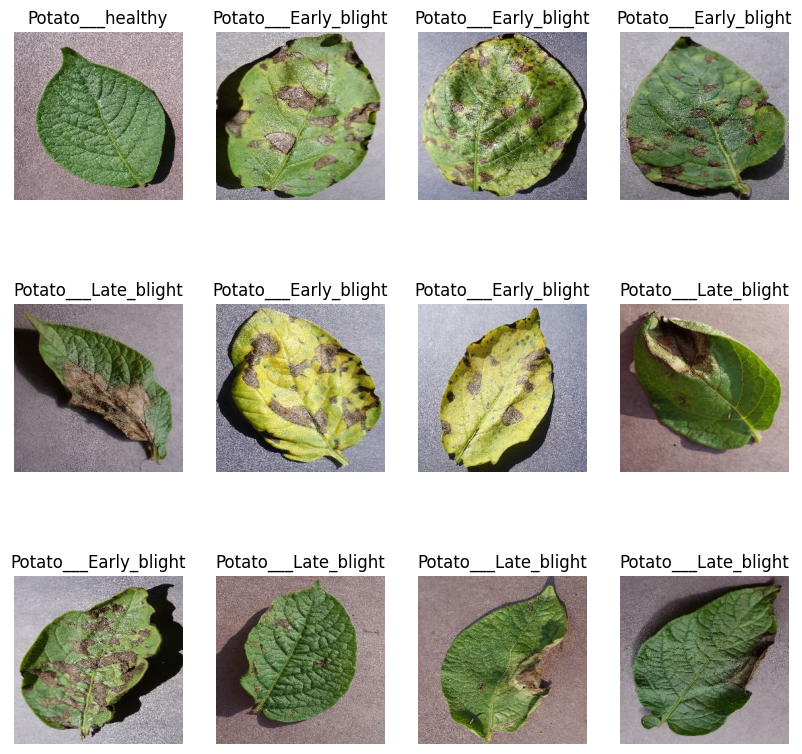

In [7]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_DS = dataset.take(54)
len(train_DS)

54

In [10]:
test_DS = dataset.skip(54)
len(test_DS)

14

In [11]:
validation_size = 0.1
len(dataset)*validation_size

6.800000000000001

In [12]:
val_DS = test_DS.take(6)
len(val_DS)

6

In [13]:
test_DS = test_DS.skip(6)
len(test_DS)


8

In [14]:
def get_dataset_partition_tf(ds, train_split = 0.8, validation_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)

    if shuffle == True:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split*ds_size)
    validation_size = int(validation_split*ds_size)

    train_dataset = ds.take(train_size)
    val_dataset = ds.skip(train_size).take(validation_size)
    test_dataset = ds.skip(train_size).skip(validation_size)

    return train_dataset, val_dataset, test_dataset
 

In [15]:
train_dataset, val_dataset, test_dataset = get_dataset_partition_tf(dataset)

In [16]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [17]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [18]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3


model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu',),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu',),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu',),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu',),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu',),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes,activation = "softmax"),
    
])

In [20]:
model.build(input_shape=input_shape)

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In Math, Logit is a function that maps probabilities ([0, 1]) to R ((-inf, inf))

L = ln(p/1-p)   p = 1/(1+e^-L)

Probability of 0.5 corresponds to a logit of 0. Negative logit correspond to probabilities less than 0.5, positive to > 0.5.

In ML, it can be

the vector of raw (non-normalized) predictions that a classification model generates, which is ordinarily then passed to a normalization function. If the model is solving a multi-class classification problem, logits typically become an input to the softmax function. The softmax function then generates a vector of (normalized) probabilities with one value for each possible class.

Logits also sometimes refer to the element-wise inverse of the sigmoid function.

In [22]:
model.compile(
    optimizer="adam",
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ["accuracy"]
)

In [23]:
history = model.fit(
    train_dataset, 
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_dataset
)

Epoch 1/5


54/54 [==============================] - 149s 3s/step - loss: 0.8965 - accuracy: 0.4815 - val_loss: 0.8823 - val_accuracy: 0.5156
Epoch 2/5
54/54 [==============================] - 127s 2s/step - loss: 0.6757 - accuracy: 0.6968 - val_loss: 0.6443 - val_accuracy: 0.7188
Epoch 3/5
54/54 [==============================] - 125s 2s/step - loss: 0.5055 - accuracy: 0.7784 - val_loss: 0.5585 - val_accuracy: 0.7135
Epoch 4/5
54/54 [==============================] - 124s 2s/step - loss: 0.4209 - accuracy: 0.8212 - val_loss: 0.4165 - val_accuracy: 0.8281
Epoch 5/5
54/54 [==============================] - 124s 2s/step - loss: 0.4261 - accuracy: 0.8420 - val_loss: 0.2829 - val_accuracy: 0.9010


In [24]:
scores = model.evaluate(test_dataset)

8/8 [==============================] - 6s 499ms/step - loss: 0.2338 - accuracy: 0.8984


In [25]:
scores

[0.23384785652160645, 0.8984375]

In [26]:
history

In [27]:
history.params

{'verbose': 1, 'epochs': 5, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

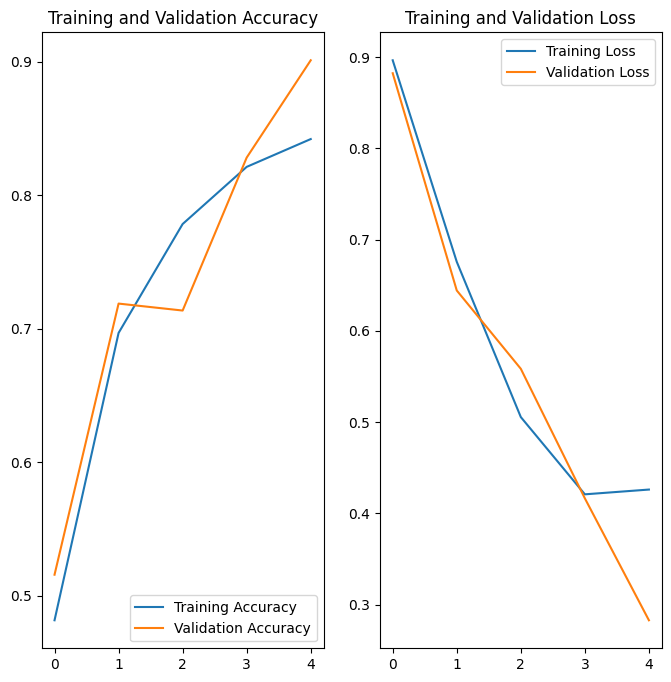

In [30]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title("Training and Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title("Training and Validation Loss")

First Image to predict
First image's actual label: Potato___Early_blight
1/1 [==============================] - 1s 857ms/step
Predicted Label: Potato___Early_blight


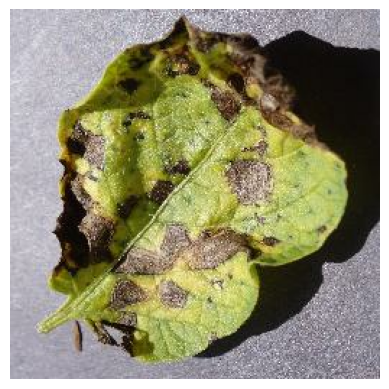

In [31]:
for image_batch, label_batch in test_dataset.take(1):
    first_image = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0]
    
    print("First Image to predict")
    plt.imshow(first_image)
    print("First image's actual label:", class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print(f"Predicted Label: {class_names[np.argmax(batch_prediction[0])]}")


    plt.axis("Off")

In [32]:
import os
model_version = max([int(i) for i in os.listdir("./models") + [0]]) + 1
model.save(f"./models/{model_version}") 

INFO:tensorflow:Assets written to: ./models/3\assets


INFO:tensorflow:Assets written to: ./models/3\assets
